# **TD3 - ConvNets**

## **Pooling**


In [96]:
import torch
from torchvision import datasets, transforms

converter = transforms.Compose([
    transforms.ToTensor()
])

training_data = datasets.MNIST(".",download=True,train=True, transform= converter)


In [97]:
images, labels = list(), list()
for i in range(16): # On prend 16 images de la dataset MNIST
    images.append(training_data[i][0])
    labels.append(training_data[i][1])
images_tensor = torch.stack(images)

### **Max Pooling**

In [98]:
pooled_max = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=3))
images_max = pooled_max(images_tensor)

### **Average Pooling**

In [99]:
pooled_average = torch.nn.Sequential(torch.nn.AvgPool2d(kernel_size=3))
images_average = pooled_average(images_tensor)

### **Min Pooling**

In [100]:
class MinPool2d(torch.nn.Module):
    def __init__(self, kernel_size):
        super(MinPool2d, self).__init__()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=kernel_size)

    def forward(self, x):
        return -self.maxpool(-x)

pooled_min = MinPool2d(kernel_size=3)
images_min = pooled_min(images_tensor)

### **Data Visualization**

In [101]:
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

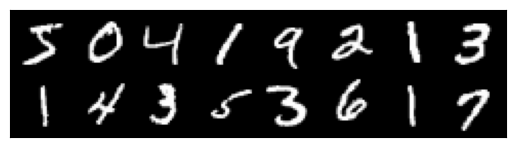

In [102]:
show(make_grid(images_tensor)) # Original Images

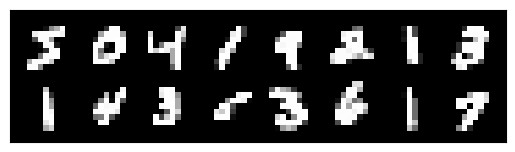

In [103]:
show(make_grid(images_max)) # Max Pooling

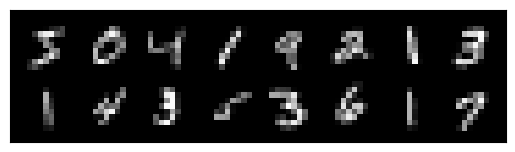

In [104]:
show(make_grid(images_average)) # Average Pooling

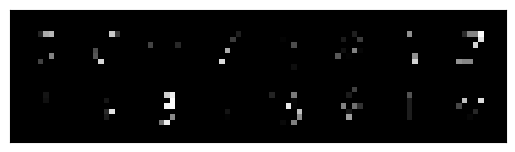

In [105]:
show(make_grid(images_min)) # Min Pooling

## **First CNN architectures**


On importe tout d'abord les jeux de données de FashionMNIST d'entraînement et de test, puis on implémente les fonctions nécessaires pour ce TD, à savoir la fonction d'entraînement des modèles, celle du test de la précision des modèles, et finalement la fonction qui permet de sauvegarder nos modèles. Notons aussi l'utilisation du GPU, qui était très utile dans la suite pour l'entraînement rapide de nos modèles.

In [106]:
transform = transforms.Compose([
    transforms.ToTensor()
    ])

training_data_fashion = datasets.FashionMNIST(".",download=True,train=True,transform=transform)
test_data_fashion = datasets.FashionMNIST(".",download=True,train=False,transform=transform)

In [107]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm


def trainer(dataset, model,loss_fn,epochs=10,batch_size=1,rate=1e-2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")

    model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=rate)

    dataset_loader = DataLoader(dataset, batch_size=batch_size)

    for epoch in tqdm(range(epochs)):

        epoch_loss = 0.0

        for batch_idx, (images, labels) in tqdm(enumerate(dataset_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=True):

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_loss = epoch_loss / len(dataset_loader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

In [108]:
def success_rate_vector(model,test_data):
  model.eval()
  proportion = 0
  n = len(test_data)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  for x,y in test_data:
    x = x.to(device)
    with torch.no_grad():
        y_pred = model(x.unsqueeze(0))
    predicted_class = torch.argmax(y_pred).item()
    if predicted_class == y:
      proportion += 1
  return proportion/n

In [109]:
import cloudpickle as pickle
from google.colab import files

def torch_saver(net,file="temp"):
  with open(file,'wb') as f:
    pickle.dump(net,f)
    files.download(file)

### **Our first CNN**


In [110]:
class firstCNN(torch.nn.Module):
    def __init__(self):
        super(firstCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, padding = 1)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride =2, padding = 1 )
        self.conv2 = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5, padding =1)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride = 2, padding = 1)
        self.conv3 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding = 2)
        self.fc = torch.nn.Linear(in_features=16 * 7 * 7, out_features=10)

    def forward(self, x):
      relu = torch.nn.ReLU()
      x1 = relu(self.maxpool1(self.conv1(x)))
      x2 = relu(self.maxpool2(self.conv2(x1)))
      x3 = relu(self.conv3(x2))
      x3 = torch.flatten(x3,start_dim=1)
      x4 = self.fc(x3)
      return x4

In [111]:
loss_10 = torch.nn.CrossEntropyLoss()
first_CNN = firstCNN()

In [112]:
trainer(training_data_fashion,  first_CNN , loss_10, epochs = 5, rate=1e-3, batch_size = 100)

Training on cpu


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5: 0it [00:00, ?it/s]

Epoch 1/5 - Loss: 0.6809


Epoch 2/5: 0it [00:00, ?it/s]

Epoch 2/5 - Loss: 0.4298


Epoch 3/5: 0it [00:00, ?it/s]

Epoch 3/5 - Loss: 0.3791


Epoch 4/5: 0it [00:00, ?it/s]

Epoch 4/5 - Loss: 0.3511


Epoch 5/5: 0it [00:00, ?it/s]

Epoch 5/5 - Loss: 0.3313


In [113]:
success_rate_vector(first_CNN, test_data_fashion)

0.8643

 **Influence of the size of the filters**

In [114]:
class firstCNN_half_depth(torch.nn.Module):
    def __init__(self):
        super(firstCNN_half_depth, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5, padding = 1)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride =2, padding = 1 )
        self.conv2 = torch.nn.Conv2d(in_channels=2, out_channels=4, kernel_size=5, padding =1)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride = 2, padding = 1)
        self.conv3 = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5, padding = 2)
        self.fc = torch.nn.Linear(in_features=8 * 7 * 7, out_features=10)

    def forward(self, x):
      relu = torch.nn.ReLU()
      x1 = relu(self.maxpool1(self.conv1(x)))
      x2 = relu(self.maxpool2(self.conv2(x1)))
      x3 = relu(self.conv3(x2))
      x3 = torch.flatten(x3,start_dim=1)
      x4 = self.fc(x3)
      return x4

In [115]:
first_CNN_half_depth = firstCNN_half_depth()

In [116]:
trainer(training_data_fashion,  first_CNN_half_depth , loss_10, epochs = 5, rate=1e-3, batch_size = 100)

Training on cpu


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5: 0it [00:00, ?it/s]

Epoch 1/5 - Loss: 0.7759


Epoch 2/5: 0it [00:00, ?it/s]

Epoch 2/5 - Loss: 0.5174


Epoch 3/5: 0it [00:00, ?it/s]

Epoch 3/5 - Loss: 0.4629


Epoch 4/5: 0it [00:00, ?it/s]

Epoch 4/5 - Loss: 0.4291


Epoch 5/5: 0it [00:00, ?it/s]

Epoch 5/5 - Loss: 0.4050


In [117]:
success_rate_vector(first_CNN_half_depth, test_data_fashion)

0.8451

**Conclusion:** en diminuant la profondeur de nos couches convolutionnelles, la précision diminue aussi.

In [118]:
class firstCNN_3(torch.nn.Module): # Avec un kernel size 3*3
    def __init__(self):
        super(firstCNN_3, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride =2, padding = 1 )
        self.conv2 = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride = 2, padding = 1)
        self.conv3 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding = 1)
        self.fc = torch.nn.Linear(in_features=16 * 7 * 7, out_features=10)

    def forward(self, x):
      relu = torch.nn.ReLU()
      x1 = relu(self.maxpool1(self.conv1(x)))
      x2 = relu(self.maxpool2(self.conv2(x1)))
      x3 = relu(self.conv3(x2))
      x3 = torch.flatten(x3,start_dim=1)
      x4 = self.fc(x3)
      return x4

In [119]:
first_CNN_3 = firstCNN_3()

In [120]:
trainer(training_data_fashion,  first_CNN_3 , loss_10, epochs = 5, rate=1e-3, batch_size = 100)

Training on cpu


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5: 0it [00:00, ?it/s]

Epoch 1/5 - Loss: 0.7420


Epoch 2/5: 0it [00:00, ?it/s]

Epoch 2/5 - Loss: 0.4570


Epoch 3/5: 0it [00:00, ?it/s]

Epoch 3/5 - Loss: 0.4093


Epoch 4/5: 0it [00:00, ?it/s]

Epoch 4/5 - Loss: 0.3824


Epoch 5/5: 0it [00:00, ?it/s]

Epoch 5/5 - Loss: 0.3626


In [121]:
success_rate_vector(first_CNN_3, test_data_fashion)

0.862

**Conclusion:** le choix entre kernel size 3 et 5 n'a pas un grand impact sur la précision de notre modèle.

**Influence of the depth of the network**

**Question 7:**

Pour firstCNN, on a 4x(5x5+1) + 8x(5x5+1) + 16x(5x5+1) + (16x7x7+1)x10 = 8578 paramètres.

Pour CNN, on a 4x(5x5 +1) + (4x28x28+1)x10 = 31 474 paramètres.

Donc, tandis que les deux modèles ont la même performance, le premier a moins de paramètres à apprendre et donc il est plus rapide.

In [153]:
class CNN(torch.nn.Module):
  def __init__(self):
     super(CNN,self).__init__()
     self.conv = torch.nn.Conv2d(in_channels= 1, out_channels= 4, kernel_size= 5, padding =2)
     self.fc = torch.nn.Linear(in_features=4*28*28, out_features=10)

  def forward(self,x):
     relu = torch.nn.ReLU()
     x1 = relu(self.conv(x))
     x1 = torch.flatten(x1,start_dim =1)
     x2 = self.fc(x1)
     return x2

In [123]:
cnn = CNN()

In [124]:
trainer(training_data_fashion, cnn, loss_10, epochs = 5, rate=1e-3, batch_size = 100)

Training on cpu


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5: 0it [00:00, ?it/s]

Epoch 1/5 - Loss: 0.5422


Epoch 2/5: 0it [00:00, ?it/s]

Epoch 2/5 - Loss: 0.4019


Epoch 3/5: 0it [00:00, ?it/s]

Epoch 3/5 - Loss: 0.3720


Epoch 4/5: 0it [00:00, ?it/s]

Epoch 4/5 - Loss: 0.3512


Epoch 5/5: 0it [00:00, ?it/s]

Epoch 5/5 - Loss: 0.3333


In [125]:
success_rate_vector(cnn, test_data_fashion)

0.8663

## **LeNet**

N.B: L'énoncé de la question 9 demande que les images d'entrées doivent être normalisées, mais en faisant ça, ma précision sur les données du test a diminué de plus de 90% à 70%, je pense que c'est dû au fait que dans le test fait dans la compétition, les images n'étaient pas normalisées (ils sont juste transformées en un tenseur), c'est pour cela que dans la suite les images ne sont pas normalisées au début.

In [126]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding = 2)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=3, stride =2, padding = 1 )
        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride = 2)
        self.fc1 = torch.nn.Linear(in_features=16 * 5* 5, out_features=120)
        self.fc2 = torch.nn.Linear(in_features=120, out_features=84)
        self.fc3 = torch.nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
      relu = torch.nn.ReLU()
      x1 = relu(self.maxpool1(self.conv1(x)))
      x2 = relu(self.maxpool2(self.conv2(x1)))
      x2 = torch.flatten(x2,start_dim=1)
      x3 = relu(self.fc1(x2))
      x4 = relu(self.fc2(x3))
      x5 = self.fc3(x4)
      return x5

In [127]:
leNet = LeNet()

In [128]:
trainer(training_data_fashion, leNet , loss_10, epochs = 25, rate=1e-3, batch_size = 100)

Training on cpu


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25: 0it [00:00, ?it/s]

Epoch 1/25 - Loss: 0.7770


Epoch 2/25: 0it [00:00, ?it/s]

Epoch 2/25 - Loss: 0.5010


Epoch 3/25: 0it [00:00, ?it/s]

Epoch 3/25 - Loss: 0.4030


Epoch 4/25: 0it [00:00, ?it/s]

Epoch 4/25 - Loss: 0.3498


Epoch 5/25: 0it [00:00, ?it/s]

Epoch 5/25 - Loss: 0.3192


Epoch 6/25: 0it [00:00, ?it/s]

Epoch 6/25 - Loss: 0.2982


Epoch 7/25: 0it [00:00, ?it/s]

Epoch 7/25 - Loss: 0.2814


Epoch 8/25: 0it [00:00, ?it/s]

Epoch 8/25 - Loss: 0.2672


Epoch 9/25: 0it [00:00, ?it/s]

Epoch 9/25 - Loss: 0.2550


Epoch 10/25: 0it [00:00, ?it/s]

Epoch 10/25 - Loss: 0.2434


Epoch 11/25: 0it [00:00, ?it/s]

Epoch 11/25 - Loss: 0.2321


Epoch 12/25: 0it [00:00, ?it/s]

Epoch 12/25 - Loss: 0.2224


Epoch 13/25: 0it [00:00, ?it/s]

Epoch 13/25 - Loss: 0.2129


Epoch 14/25: 0it [00:00, ?it/s]

Epoch 14/25 - Loss: 0.2048


Epoch 15/25: 0it [00:00, ?it/s]

Epoch 15/25 - Loss: 0.1969


Epoch 16/25: 0it [00:00, ?it/s]

Epoch 16/25 - Loss: 0.1895


Epoch 17/25: 0it [00:00, ?it/s]

Epoch 17/25 - Loss: 0.1822


Epoch 18/25: 0it [00:00, ?it/s]

Epoch 18/25 - Loss: 0.1755


Epoch 19/25: 0it [00:00, ?it/s]

Epoch 19/25 - Loss: 0.1683


Epoch 20/25: 0it [00:00, ?it/s]

Epoch 20/25 - Loss: 0.1615


Epoch 21/25: 0it [00:00, ?it/s]

Epoch 21/25 - Loss: 0.1553


Epoch 22/25: 0it [00:00, ?it/s]

Epoch 22/25 - Loss: 0.1500


Epoch 23/25: 0it [00:00, ?it/s]

Epoch 23/25 - Loss: 0.1442


Epoch 24/25: 0it [00:00, ?it/s]

Epoch 24/25 - Loss: 0.1402


Epoch 25/25: 0it [00:00, ?it/s]

Epoch 25/25 - Loss: 0.1375


In [129]:
success_rate_vector(leNet, test_data_fashion)

0.9047

## **Parameter sharing**


In [130]:
import torchvision.models as models
# load pretrained model
alexnet = models.alexnet(pretrained=True)
# access weights from first layer
filter = alexnet.features[0].weight.data
# normalize to [0, 1]
filter = (1/(2*filter.max()))*filter + 0.5

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 101MB/s] 


Ci-dessous, quand on visualise les filtres de la première couche d'AlexNet, on voit bien des motifs simples et basiques, comme des bords et des textures. Ces filtres sont ensuite combinés dans les couches suivantes du réseau pour détecter des caractéristiques de plus en plus complexes.

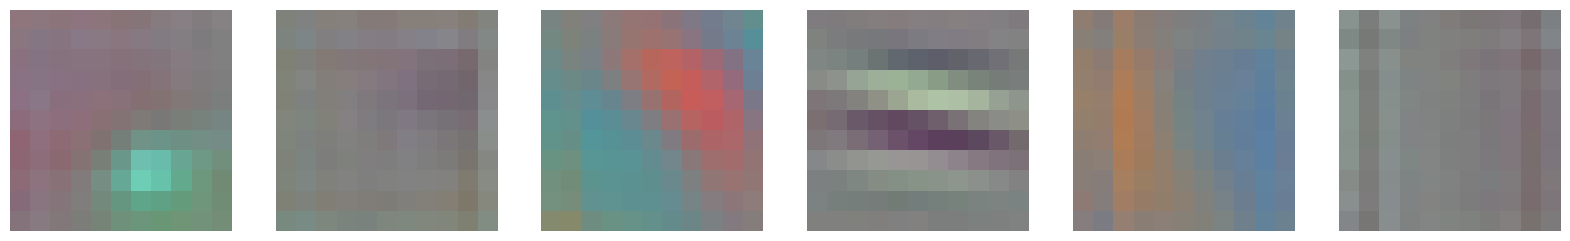

In [155]:
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axarr[i].imshow(filter[i].cpu().numpy().transpose(1, 2, 0))
    axarr[i].axis('off')
plt.show()

## **Your Model for TD3**

Pour cette dernière section, je présente l'ensembles des modèles et méthodes que j'ai envisagé afin d'obtenir finalement une précision de 93.5%.

### **Ajout d'un dropout**

Tout d'abord, ma première idée était d'ajouter un dropout de 0.5 afin d'éviter l'overfit de mon modèle, j'ai ajouté aussi des BatchNorm afin d'assurer une convergence plus rapide des paramètres de mon modèle.

In [131]:
class customLeNet(torch.nn.Module):
    def __init__(self):
        super(customLeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding = 2)
        self.batchnorm1 = torch.nn.BatchNorm2d(8)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=3, stride =2, padding = 1 )

        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.batchnorm2 = torch.nn.BatchNorm2d(16)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride = 2)

        self.fc1 = torch.nn.Linear(in_features=16 * 5* 5, out_features=200)
        self.drop = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(in_features=200, out_features=100)
        self.fc3 = torch.nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
      relu = torch.nn.ReLU()
      x1 = self.maxpool1(relu(self.batchnorm1(self.conv1(x))))
      x2 = self.maxpool2(relu(self.batchnorm2(self.conv2(x1))))
      x2 = torch.flatten(x2,start_dim=1)
      x3 = relu(self.fc1(x2))
      x3 = self.drop(x3)
      x4 = relu(self.fc2(x3))
      x5 = self.fc3(x4)
      return x5

In [132]:
custom_net = customLeNet()

In [133]:
trainer(training_data_fashion, custom_net , loss_10, epochs = 25, rate=1e-3, batch_size = 100)

Training on cpu


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25: 0it [00:00, ?it/s]

Epoch 1/25 - Loss: 0.5418


Epoch 2/25: 0it [00:00, ?it/s]

Epoch 2/25 - Loss: 0.3633


Epoch 3/25: 0it [00:00, ?it/s]

Epoch 3/25 - Loss: 0.3226


Epoch 4/25: 0it [00:00, ?it/s]

Epoch 4/25 - Loss: 0.2977


Epoch 5/25: 0it [00:00, ?it/s]

Epoch 5/25 - Loss: 0.2828


Epoch 6/25: 0it [00:00, ?it/s]

Epoch 6/25 - Loss: 0.2696


Epoch 7/25: 0it [00:00, ?it/s]

Epoch 7/25 - Loss: 0.2565


Epoch 8/25: 0it [00:00, ?it/s]

Epoch 8/25 - Loss: 0.2510


Epoch 9/25: 0it [00:00, ?it/s]

Epoch 9/25 - Loss: 0.2428


Epoch 10/25: 0it [00:00, ?it/s]

Epoch 10/25 - Loss: 0.2328


Epoch 11/25: 0it [00:00, ?it/s]

Epoch 11/25 - Loss: 0.2255


Epoch 12/25: 0it [00:00, ?it/s]

Epoch 12/25 - Loss: 0.2223


Epoch 13/25: 0it [00:00, ?it/s]

Epoch 13/25 - Loss: 0.2156


Epoch 14/25: 0it [00:00, ?it/s]

Epoch 14/25 - Loss: 0.2088


Epoch 15/25: 0it [00:00, ?it/s]

Epoch 15/25 - Loss: 0.2054


Epoch 16/25: 0it [00:00, ?it/s]

Epoch 16/25 - Loss: 0.2009


Epoch 17/25: 0it [00:00, ?it/s]

Epoch 17/25 - Loss: 0.1953


Epoch 18/25: 0it [00:00, ?it/s]

Epoch 18/25 - Loss: 0.1920


Epoch 19/25: 0it [00:00, ?it/s]

Epoch 19/25 - Loss: 0.1867


Epoch 20/25: 0it [00:00, ?it/s]

Epoch 20/25 - Loss: 0.1853


Epoch 21/25: 0it [00:00, ?it/s]

Epoch 21/25 - Loss: 0.1821


Epoch 22/25: 0it [00:00, ?it/s]

Epoch 22/25 - Loss: 0.1793


Epoch 23/25: 0it [00:00, ?it/s]

Epoch 23/25 - Loss: 0.1756


Epoch 24/25: 0it [00:00, ?it/s]

Epoch 24/25 - Loss: 0.1729


Epoch 25/25: 0it [00:00, ?it/s]

Epoch 25/25 - Loss: 0.1714


In [134]:
success_rate_vector(custom_net, test_data_fashion)

0.9073

### **LeNet modifié**

Ma deuxième approche était d'augmenter le depth de mes couches convolutionnelles, en passant de 8 et 16 à 32 et 64.

In [135]:
class customLeNet2(torch.nn.Module):
    def __init__(self):
        super(customLeNet2, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding = 2)
        self.batchnorm1 = torch.nn.BatchNorm2d(32)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=3, stride =2, padding = 1 )

        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.batchnorm2 = torch.nn.BatchNorm2d(64)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride = 2)

        self.fc1 = torch.nn.Linear(in_features=64 * 5* 5, out_features=512)
        self.drop = torch.nn.Dropout2d(0.5)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=120)
        self.fc3 = torch.nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
      relu = torch.nn.ReLU()
      x1 = self.maxpool1( relu( self.batchnorm1( self.conv1(x) ) ) )
      x2 = self.maxpool2( relu( self.batchnorm2( self.conv2(x1) ) ) )
      x2 = torch.flatten(x2,start_dim=1)
      x3 = relu(self.fc1(x2))
      x3 = self.drop(x3)
      x4 = relu(self.fc2(x3))
      x5 = self.fc3(x4)
      return x5

In [136]:
custom_net_2 = customLeNet2()

In [137]:
trainer(training_data_fashion,  custom_net_2 , loss_10, epochs = 25, rate=1e-3, batch_size = 100)

Training on cpu


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25: 0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/25 - Loss: 0.4477


Epoch 2/25: 0it [00:00, ?it/s]

Epoch 2/25 - Loss: 0.3075


Epoch 3/25: 0it [00:00, ?it/s]

Epoch 3/25 - Loss: 0.2650


Epoch 4/25: 0it [00:00, ?it/s]

Epoch 4/25 - Loss: 0.2423


Epoch 5/25: 0it [00:00, ?it/s]

Epoch 5/25 - Loss: 0.2225


Epoch 6/25: 0it [00:00, ?it/s]

Epoch 6/25 - Loss: 0.2056


Epoch 7/25: 0it [00:00, ?it/s]

Epoch 7/25 - Loss: 0.1901


Epoch 8/25: 0it [00:00, ?it/s]

Epoch 8/25 - Loss: 0.1774


Epoch 9/25: 0it [00:00, ?it/s]

Epoch 9/25 - Loss: 0.1686


Epoch 10/25: 0it [00:00, ?it/s]

Epoch 10/25 - Loss: 0.1562


Epoch 11/25: 0it [00:00, ?it/s]

Epoch 11/25 - Loss: 0.1479


Epoch 12/25: 0it [00:00, ?it/s]

Epoch 12/25 - Loss: 0.1379


Epoch 13/25: 0it [00:00, ?it/s]

Epoch 13/25 - Loss: 0.1257


Epoch 14/25: 0it [00:00, ?it/s]

Epoch 14/25 - Loss: 0.1226


Epoch 15/25: 0it [00:00, ?it/s]

Epoch 15/25 - Loss: 0.1111


Epoch 16/25: 0it [00:00, ?it/s]

Epoch 16/25 - Loss: 0.1087


Epoch 17/25: 0it [00:00, ?it/s]

Epoch 17/25 - Loss: 0.1023


Epoch 18/25: 0it [00:00, ?it/s]

Epoch 18/25 - Loss: 0.0967


Epoch 19/25: 0it [00:00, ?it/s]

Epoch 19/25 - Loss: 0.0914


Epoch 20/25: 0it [00:00, ?it/s]

Epoch 20/25 - Loss: 0.0874


Epoch 21/25: 0it [00:00, ?it/s]

Epoch 21/25 - Loss: 0.0824


Epoch 22/25: 0it [00:00, ?it/s]

Epoch 22/25 - Loss: 0.0787


Epoch 23/25: 0it [00:00, ?it/s]

Epoch 23/25 - Loss: 0.0768


Epoch 24/25: 0it [00:00, ?it/s]

Epoch 24/25 - Loss: 0.0724


Epoch 25/25: 0it [00:00, ?it/s]

Epoch 25/25 - Loss: 0.0699


In [138]:
success_rate_vector(custom_net_2, test_data_fashion)

0.9165

### **LeNet avec kernel size 3**

Ensuite, j'ai changé le kernel size à 3*3.

In [139]:
class customLeNet3(torch.nn.Module):
    def __init__(self):
        super(customLeNet3, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding = 1)
        self.batchnorm1 = torch.nn.BatchNorm2d(16)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride =2, padding = 1 )

        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=30, kernel_size=3)
        self.batchnorm2 = torch.nn.BatchNorm2d(30)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride = 2)

        self.fc1 = torch.nn.Linear(in_features=30 * 6* 6, out_features=450)
        self.drop = torch.nn.Dropout2d(0.5)
        self.fc2 = torch.nn.Linear(in_features=450, out_features=120)
        self.fc3 = torch.nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
      relu = torch.nn.ReLU()
      x1 = self.maxpool1( relu( self.batchnorm1( self.conv1(x) ) ) )
      x2 = self.maxpool2( relu( self.batchnorm2( self.conv2(x1) ) ) )
      x2 = torch.flatten(x2,start_dim=1)
      x3 = relu(self.fc1(x2))
      x3 = self.drop(x3)
      x4 = relu(self.fc2(x3))
      x5 = self.fc3(x4)
      return x5

In [140]:
custom_net_3 = customLeNet3()

In [141]:
trainer(training_data_fashion, custom_net_3 , loss_10, epochs = 25, rate=1e-3, batch_size = 100)

Training on cpu


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25: 0it [00:00, ?it/s]

Epoch 1/25 - Loss: 0.4671


Epoch 2/25: 0it [00:00, ?it/s]

Epoch 2/25 - Loss: 0.3236


Epoch 3/25: 0it [00:00, ?it/s]

Epoch 3/25 - Loss: 0.2841


Epoch 4/25: 0it [00:00, ?it/s]

Epoch 4/25 - Loss: 0.2574


Epoch 5/25: 0it [00:00, ?it/s]

Epoch 5/25 - Loss: 0.2396


Epoch 6/25: 0it [00:00, ?it/s]

Epoch 6/25 - Loss: 0.2235


Epoch 7/25: 0it [00:00, ?it/s]

Epoch 7/25 - Loss: 0.2096


Epoch 8/25: 0it [00:00, ?it/s]

Epoch 8/25 - Loss: 0.1954


Epoch 9/25: 0it [00:00, ?it/s]

Epoch 9/25 - Loss: 0.1829


Epoch 10/25: 0it [00:00, ?it/s]

Epoch 10/25 - Loss: 0.1719


Epoch 11/25: 0it [00:00, ?it/s]

Epoch 11/25 - Loss: 0.1618


Epoch 12/25: 0it [00:00, ?it/s]

Epoch 12/25 - Loss: 0.1552


Epoch 13/25: 0it [00:00, ?it/s]

Epoch 13/25 - Loss: 0.1476


Epoch 14/25: 0it [00:00, ?it/s]

Epoch 14/25 - Loss: 0.1371


Epoch 15/25: 0it [00:00, ?it/s]

Epoch 15/25 - Loss: 0.1300


Epoch 16/25: 0it [00:00, ?it/s]

Epoch 16/25 - Loss: 0.1236


Epoch 17/25: 0it [00:00, ?it/s]

Epoch 17/25 - Loss: 0.1172


Epoch 18/25: 0it [00:00, ?it/s]

Epoch 18/25 - Loss: 0.1103


Epoch 19/25: 0it [00:00, ?it/s]

Epoch 19/25 - Loss: 0.1082


Epoch 20/25: 0it [00:00, ?it/s]

Epoch 20/25 - Loss: 0.1027


Epoch 21/25: 0it [00:00, ?it/s]

Epoch 21/25 - Loss: 0.0979


Epoch 22/25: 0it [00:00, ?it/s]

Epoch 22/25 - Loss: 0.0959


Epoch 23/25: 0it [00:00, ?it/s]

Epoch 23/25 - Loss: 0.0886


Epoch 24/25: 0it [00:00, ?it/s]

Epoch 24/25 - Loss: 0.0866


Epoch 25/25: 0it [00:00, ?it/s]

Epoch 25/25 - Loss: 0.0862


In [142]:
success_rate_vector(custom_net_3, test_data_fashion)

0.9115

### **Model with Augmented Data**

Pour palier plus à l'overfit de mes modèles précédants, j'ai utilisé la méthode de l'augmentation de mes données en faisant des transformations aléatoires sur mes images d'entrée pendant l'entraînement, cela a bien permis d'augmenter la précision de mes modèles.

In [143]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

train_data_fashion_augmented = datasets.FashionMNIST(".",download=True,train=True,transform=train_transforms)

In [144]:
custom_net_augmented = customLeNet()

In [145]:
trainer(train_data_fashion_augmented, custom_net_augmented , loss_10, epochs = 25, rate=1e-3, batch_size = 100)

Training on cpu


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25: 0it [00:00, ?it/s]

Epoch 1/25 - Loss: 0.7285


Epoch 2/25: 0it [00:00, ?it/s]

Epoch 2/25 - Loss: 0.5529


Epoch 3/25: 0it [00:00, ?it/s]

Epoch 3/25 - Loss: 0.5047


Epoch 4/25: 0it [00:00, ?it/s]

Epoch 4/25 - Loss: 0.4741


Epoch 5/25: 0it [00:00, ?it/s]

Epoch 5/25 - Loss: 0.4546


Epoch 6/25: 0it [00:00, ?it/s]

Epoch 6/25 - Loss: 0.4400


Epoch 7/25: 0it [00:00, ?it/s]

Epoch 7/25 - Loss: 0.4295


Epoch 8/25: 0it [00:00, ?it/s]

Epoch 8/25 - Loss: 0.4207


Epoch 9/25: 0it [00:00, ?it/s]

Epoch 9/25 - Loss: 0.4132


Epoch 10/25: 0it [00:00, ?it/s]

Epoch 10/25 - Loss: 0.4059


Epoch 11/25: 0it [00:00, ?it/s]

Epoch 11/25 - Loss: 0.3989


Epoch 12/25: 0it [00:00, ?it/s]

Epoch 12/25 - Loss: 0.3968


Epoch 13/25: 0it [00:00, ?it/s]

Epoch 13/25 - Loss: 0.3942


Epoch 14/25: 0it [00:00, ?it/s]

Epoch 14/25 - Loss: 0.3900


Epoch 15/25: 0it [00:00, ?it/s]

Epoch 15/25 - Loss: 0.3820


Epoch 16/25: 0it [00:00, ?it/s]

Epoch 16/25 - Loss: 0.3793


Epoch 17/25: 0it [00:00, ?it/s]

Epoch 17/25 - Loss: 0.3750


Epoch 18/25: 0it [00:00, ?it/s]

Epoch 18/25 - Loss: 0.3740


Epoch 19/25: 0it [00:00, ?it/s]

Epoch 19/25 - Loss: 0.3696


Epoch 20/25: 0it [00:00, ?it/s]

Epoch 20/25 - Loss: 0.3685


Epoch 21/25: 0it [00:00, ?it/s]

Epoch 21/25 - Loss: 0.3641


Epoch 22/25: 0it [00:00, ?it/s]

Epoch 22/25 - Loss: 0.3625


Epoch 23/25: 0it [00:00, ?it/s]

Epoch 23/25 - Loss: 0.3611


Epoch 24/25: 0it [00:00, ?it/s]

Epoch 24/25 - Loss: 0.3593


Epoch 25/25: 0it [00:00, ?it/s]

Epoch 25/25 - Loss: 0.3548


In [146]:
success_rate_vector(custom_net_augmented, test_data_fashion)

0.8962

In [147]:
custom_net_3_augmented = customLeNet3()

In [148]:
trainer(train_data_fashion_augmented, custom_net_3_augmented , loss_10, epochs = 25, rate=1e-3, batch_size = 100)

Training on cpu


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25: 0it [00:00, ?it/s]

Epoch 1/25 - Loss: 0.6538


Epoch 2/25: 0it [00:00, ?it/s]

Epoch 2/25 - Loss: 0.4919


Epoch 3/25: 0it [00:00, ?it/s]

Epoch 3/25 - Loss: 0.4466


Epoch 4/25: 0it [00:00, ?it/s]

Epoch 4/25 - Loss: 0.4220


Epoch 5/25: 0it [00:00, ?it/s]

Epoch 5/25 - Loss: 0.4001


Epoch 6/25: 0it [00:00, ?it/s]

Epoch 6/25 - Loss: 0.3882


Epoch 7/25: 0it [00:00, ?it/s]

Epoch 7/25 - Loss: 0.3751


Epoch 8/25: 0it [00:00, ?it/s]

Epoch 8/25 - Loss: 0.3671


Epoch 9/25: 0it [00:00, ?it/s]

Epoch 9/25 - Loss: 0.3609


Epoch 10/25: 0it [00:00, ?it/s]

Epoch 10/25 - Loss: 0.3507


Epoch 11/25: 0it [00:00, ?it/s]

Epoch 11/25 - Loss: 0.3460


Epoch 12/25: 0it [00:00, ?it/s]

Epoch 12/25 - Loss: 0.3389


Epoch 13/25: 0it [00:00, ?it/s]

Epoch 13/25 - Loss: 0.3349


Epoch 14/25: 0it [00:00, ?it/s]

Epoch 14/25 - Loss: 0.3320


Epoch 15/25: 0it [00:00, ?it/s]

Epoch 15/25 - Loss: 0.3276


Epoch 16/25: 0it [00:00, ?it/s]

Epoch 16/25 - Loss: 0.3233


Epoch 17/25: 0it [00:00, ?it/s]

Epoch 17/25 - Loss: 0.3159


Epoch 18/25: 0it [00:00, ?it/s]

Epoch 18/25 - Loss: 0.3152


Epoch 19/25: 0it [00:00, ?it/s]

Epoch 19/25 - Loss: 0.3131


Epoch 20/25: 0it [00:00, ?it/s]

Epoch 20/25 - Loss: 0.3090


Epoch 21/25: 0it [00:00, ?it/s]

Epoch 21/25 - Loss: 0.3065


Epoch 22/25: 0it [00:00, ?it/s]

Epoch 22/25 - Loss: 0.3056


Epoch 23/25: 0it [00:00, ?it/s]

Epoch 23/25 - Loss: 0.3083


Epoch 24/25: 0it [00:00, ?it/s]

Epoch 24/25 - Loss: 0.2996


Epoch 25/25: 0it [00:00, ?it/s]

Epoch 25/25 - Loss: 0.2969


In [149]:
success_rate_vector(custom_net_3_augmented,test_data_fashion)

0.9127

### **Combining models**

Finalement, j'ai combiné certains des modèles précédants, en jouant sur les poids affectés, cela m'a bien permis d'atteindre une précision allant jusqu'à 93.6%.

In [157]:
class combinedModel(torch.nn.Module):
  def __init__(self,model1,model2,model3,model4):
    super(combinedModel, self).__init__()
    self.model1 = model1
    self.model2 = model2
    self.model3 = model3
    self.model4 = model4

  def forward(self,x):
    output1 = self.model1(x)
    output2 = self.model2(x)
    output3 = self.model3(x)
    output4 = self.model4(x)

    output = (output1 + output2 + output3 + output4 )/4
    return output

In [158]:
combinedNet = combinedModel(leNet, custom_net, custom_net_2, custom_net_3_augmented)

In [159]:
success_rate_vector(combinedNet, test_data_fashion)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.9251

Remarque: dans ce rendu, je suis arrivé juste à 92.51% vu que j'ai pas utilisé un grand nombre d'épochs (pour la précision de 93.9% j'ai utilisé entre 50 et 100 epochs pour chaque modèle), cela est dû au fait que j'ai plus accès au GPU sur colab.